# Early Stage Diabetes Risk Prediction

## Problem Statement


From dataset, trying to predict whether a patient has diabetes or not.

## The Dataset

The dataset contains medical data of patients along with their diabetes status.
- `age`: age of the patient
- `gender`: gender of the patient
- `bmi`: body mass index of the patient
- `hypertension`: hypertension status of the patient (chronic condition where the blood pressure is too high)
- `heart_disease`: heart disease status of the patient
- `smoking_history`: smoking history of the patient (never, No Info, current, former, not current, ever)
- `HbA1c_level` - result of glucose level blood test which measures blood sugar level over the past 2-3 months.
- `blood_glucose_level` - blood glucose level of the patient

Note: If I were to re-do this project, I would get the data from a more established source, as the origins of this dataset are unclear.

https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


There are 100,000 entries in this dataset. On first appearances, there are no null values.

## Data pre-processing

Most of the features are numerical. Only gender and smoking_history are categorical and will later need to be turned numerical.

Hypertension, heart_disease and diabetes are all binary features.

In [4]:
df["smoking_history"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

Around 36% of entries are missing smoking_history info. This would be quite a lot of data to drop, so I will not drop them.

Instead, I will use Mode Category Imputation based on gender and age.

In [5]:
# This function takes all entries within an age range as a parameter
# It returns the most common value for 'smoking_history' that is not 'No Info'
def get_mode_smoking_history_from_group(group):
    value_counts = group.value_counts()    
    most_common = value_counts.index[0] if value_counts.index[0] != "No Info" else value_counts.index[1]    
    return most_common

# Group all entries into age_group bins of width 5 (years). 
# Replace all smoking_history values of 'No Info' with the most common value in the respective age group.
df['age_group'] = pd.cut(df['age'], bins=np.arange(0, df["age"].max(), 5), right=False)
df['smoking_history_of_age_group'] = df.groupby('age_group')['smoking_history'].transform(lambda x: get_mode_smoking_history_from_group(x))
df.loc[df['smoking_history'] == 'No Info', 'smoking_history'] = df['smoking_history_of_age_group']

# Check that there are no more counts for 'No Info'
df["smoking_history"].value_counts()

/var/folders/nl/l_thjhtd7s13pv8s4s13w7nh0000gn/T/ipykernel_44213/969091834.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['smoking_history_of_age_group'] = df.groupby('age_group')['smoking_history'].transform(lambda x: get_mode_smoking_history_from_group(x))


smoking_history
never          68123
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

We have now replaced all instances of "No info"

In [6]:
df["gender"].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [7]:
# For the gender other, show all the unique values for the 'diabetes' feature
df[df["gender"] == "Other"]["diabetes"].value_counts()

diabetes
0    18
Name: count, dtype: int64

Out of 100,000 entries, there are only 18 entries with the gender 'Other'. 18 data points is not enough to make assumptions on the greater population. Furthermore, all 18 of these patients do not have diabetes. I will drop these entries.

In [8]:
df = df[df['gender'] != 'Other']
df['gender'].describe()

count      99982
unique         2
top       Female
freq       58552
Name: gender, dtype: object

## Exploratory Analysis

I want to first look at the categorical features (gender and smoking_history) to see if there is correlation between them and being positive for diabetes.

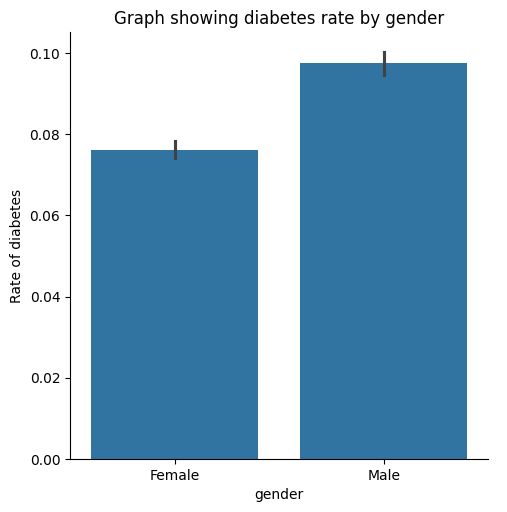

In [9]:
sns.catplot(
    data=df, x="gender", y="diabetes",
    kind="bar"
)
plt.ylabel("Rate of diabetes")
plt.title("Graph showing diabetes rate by gender")
plt.savefig('images/gender_diabetes.png')
plt.show()

From the graph, it seems that male patients have higher rates of diabetes.

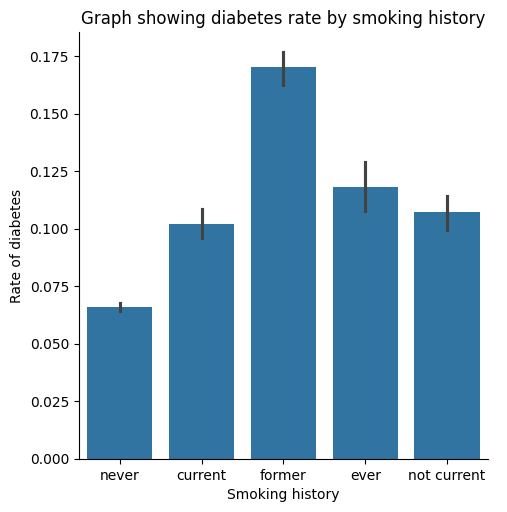

In [10]:
sns.catplot(
    data=df, x="smoking_history", y="diabetes",
    kind="bar"
)
plt.ylabel("Rate of diabetes")
plt.xlabel("Smoking history")
plt.title("Graph showing diabetes rate by smoking history")
plt.savefig('images/smoking_diabetes.png')
plt.show()

This graph seems to show that there is a correlation between smoking history and rates of diabetes. Those who have never smoked have lowest rates of diabetes where was those who were former smokers have highest rates of diabetes.

Next, I'm going to look at the numerical features and see their correlations with diabetes rates.

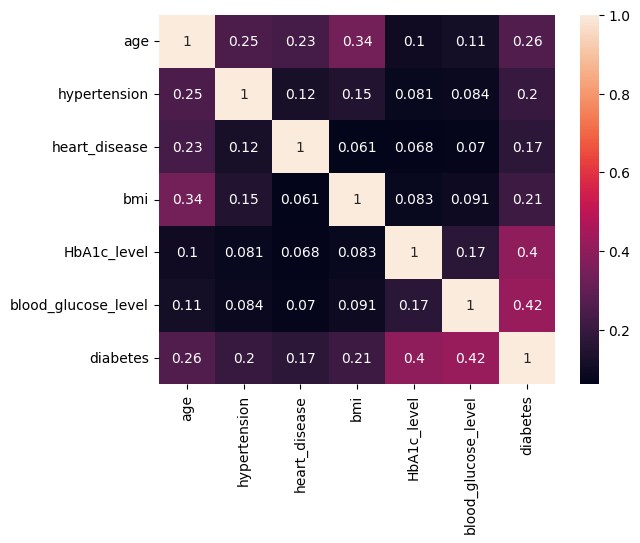

In [11]:
# Create a correlation matrix between all features
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True)
plt.savefig('images/correlation_heatmap.png')

It seems that there are positive correlations between diabetes and all the other numerical features. The strongest correlations are with blood_glucose_level and HbA1c_level. 

There are no correlations between the other features that are high enough to make me suspect multicollinearity.

I could visualise these correlations using box plots (as I do for blood_glucose_level below), but the correlation heatmap is enough for me to determine that I will include all of the numerical features in the prediction model.

Text(0.5, 1.0, 'Box plots showing the distribution of Blood Glucose Levels for people wiht and without diabetes')

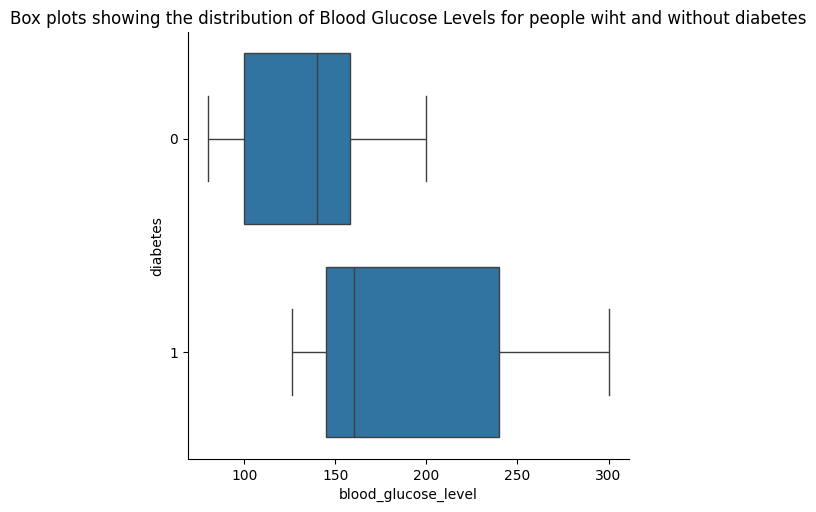

In [12]:
df['diabetes'] = df['diabetes'].astype('category')
sns.catplot(data=df, x="blood_glucose_level", y="diabetes", kind="box")
plt.title("Box plots showing the distribution of Blood Glucose Levels for people wiht and without diabetes")

## Categorical Feature Encoding

Since there are now 2 values for gender, I will turn the feature into a binary feature.

In [13]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

I will also one-hot encode the smoking_history column.

In [14]:
df = df.join(pd.get_dummies(df.smoking_history, prefix="smoking_history", dtype=int))
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group,smoking_history_of_age_group,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,80.0,0,1,never,25.19,6.6,140,0,NaN,NaN,0,0,0,1,0
1,0,54.0,0,0,never,27.32,6.6,80,0,"[50.0, 55.0)",never,0,0,0,1,0
2,1,28.0,0,0,never,27.32,5.7,158,0,"[25.0, 30.0)",never,0,0,0,1,0
3,0,36.0,0,0,current,23.45,5.0,155,0,"[35.0, 40.0)",never,1,0,0,0,0
4,1,76.0,1,1,current,20.14,4.8,155,0,NaN,NaN,1,0,0,0,0


## Numerical Variables Normalisation

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'HbA1c_level'}>,
        <Axes: title={'center': 'blood_glucose_level'}>]], dtype=object)

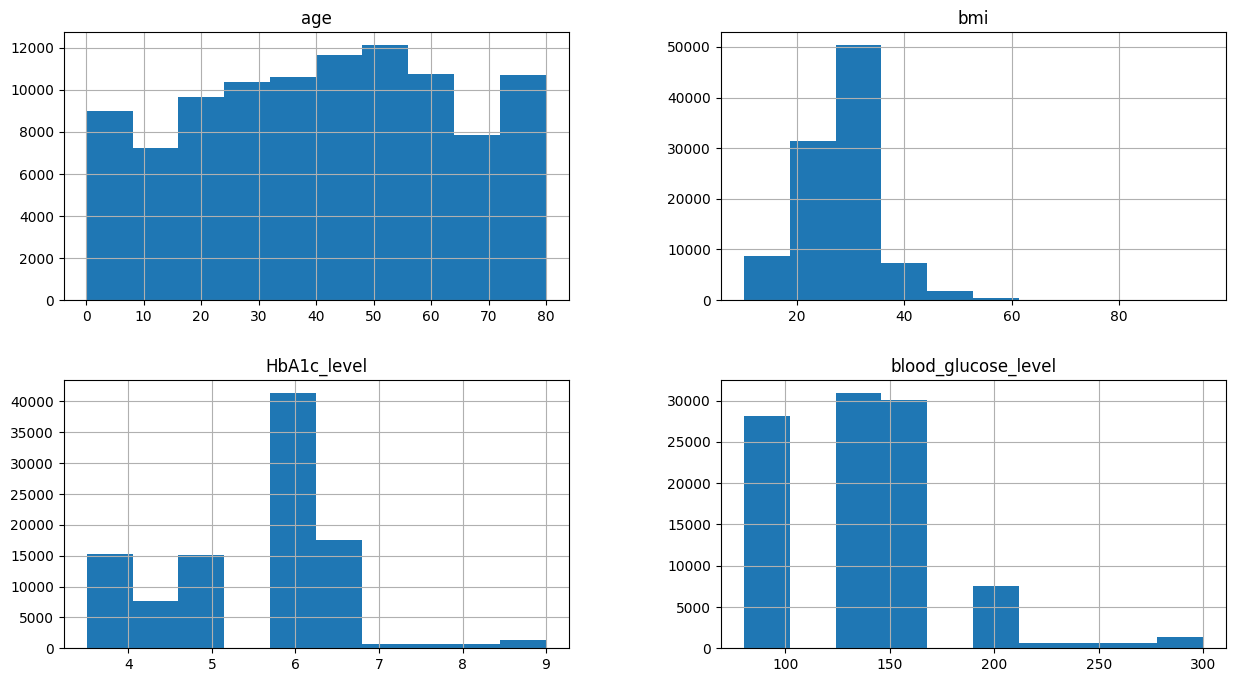

In [15]:
df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']].hist(figsize=(15,8))

I'm going to normalise the non-binary numerical features. This ensures that features are on the same scale to speed up and stabilise convergence (which will be useful in the case of logistic regression later on)

In [16]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()
columns_to_normalise = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# Apply Min-Max normalization to specified columns
df[columns_to_normalise] = scaler.fit_transform(df[columns_to_normalise])
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group,smoking_history_of_age_group,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,1.000000,0,1,never,0.177171,0.563636,0.272727,0,NaN,NaN,0,0,0,1,0
1,0,0.674675,0,0,never,0.202031,0.563636,0.000000,0,"[50.0, 55.0)",never,0,0,0,1,0
2,1,0.349349,0,0,never,0.202031,0.400000,0.354545,0,"[25.0, 30.0)",never,0,0,0,1,0
3,0,0.449449,0,0,current,0.156863,0.272727,0.340909,0,"[35.0, 40.0)",never,1,0,0,0,0
4,1,0.949950,1,1,current,0.118231,0.236364,0.340909,0,NaN,NaN,1,0,0,0,0


## Sampling for a balanced dataset

In [17]:
df.diabetes.value_counts()

diabetes
0    91482
1     8500
Name: count, dtype: int64

As shown above, the dataset is not balanced. There are a lot more entries for people who do not have diabetes. I would like a more balanced dataset to improve model performance. It will also help with evaluating the model more accurately.

In [18]:
diabetic = df[df.diabetes == 1] 
not_diabetic = df[df.diabetes == 0] 
n = min([len(diabetic), len(not_diabetic)]) 
diabetic_sample = diabetic.sample(n = n, random_state = 0) 
not_diabetic_sample = not_diabetic.sample(n = n, random_state = 0)
df = pd.concat([diabetic_sample, not_diabetic_sample]) 

In [19]:
len(df)

17000

A major downside of using stratified sampling to balance the dataset is that we are left with 17,000 entries as opposed to close to 100,000 before.
However, 17,000 entries is still plenty for an ML model.

## Train-test split

I'm going to split the dataset into training and test datasets.
I will only include select features in the dataset.

In [20]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group,smoking_history_of_age_group,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
95388,0,1.000000,0,0,never,0.202031,0.400000,0.209091,1,NaN,NaN,0,0,0,1,0
64699,1,0.737237,1,0,former,0.253735,0.963636,0.909091,1,"[55.0, 60.0)",never,0,0,1,0,0
4527,0,0.486987,0,0,never,0.266106,0.472727,0.340909,1,"[35.0, 40.0)",never,0,0,0,1,0
2596,0,0.874875,1,1,not current,0.248366,0.963636,0.909091,1,"[70.0, 75.0)",never,0,0,0,0,1
48568,1,0.574575,1,0,never,0.340103,0.600000,0.209091,1,"[45.0, 50.0)",never,0,0,0,1,0


In [21]:
feature_list = ['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']
X = df[feature_list]
y = df[['diabetes']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
)

## Logistic Regression

I'm going to create a logistic regression model.

In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [23]:
y_pred_class = logreg.predict(X_test)

from sklearn import metrics
print('Accuracy score is:',metrics.accuracy_score(y_test, y_pred_class))

Accuracy score is: 0.885


In [24]:
from sklearn import metrics
# Calculate the class probability
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
auc_score = metrics.roc_auc_score(y_test.values.ravel(), y_pred_prob)
print(f"AUC score: {auc_score}")

AUC score: 0.9611000856468064


The AUC score is very close to 1. This means that the true positive rate is high and the false positive rate is low.

To visualise this, I will plot the ROC curve.

Text(0, 0.5, 'True Positive Rate')

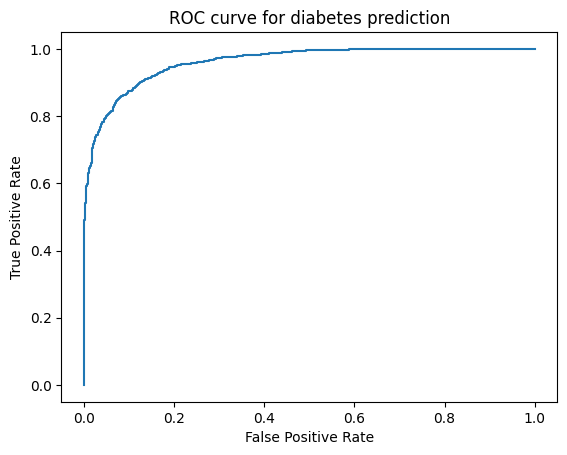

In [25]:
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_test, y_pred_prob)
fig = plt.plot(fpr_logreg, tpr_logreg,label='ROC curve (area = %0.2f)' % auc_score )
plt.title('ROC curve for diabetes prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_test)
print('Accuracy score is:', metrics.accuracy_score(y_test, y_pred_dtree))

Accuracy score is: 0.875


In [27]:
y_pred_prob_dtree = dtree.predict_proba(X_test)[:,1]
auc_score_dtree = metrics.roc_auc_score(y_test.values.ravel(), y_pred_prob_dtree)
print(f"AUC score: {auc_score_dtree}")

AUC score: 0.8749883641459976


## Comparison

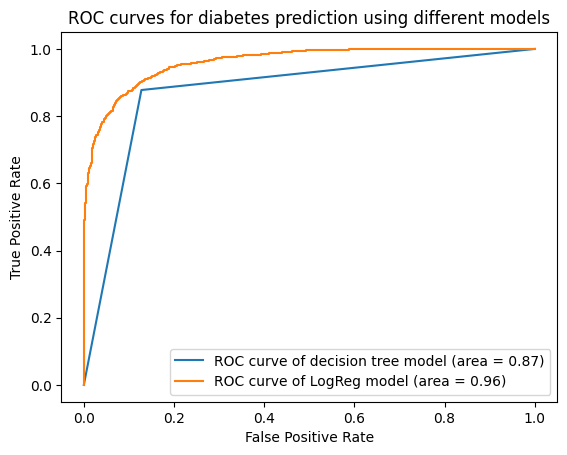

In [28]:
fpr_dtree, tpr_dtree, _ = metrics.roc_curve(y_test, y_pred_prob_dtree)
fig = plt.plot(fpr_dtree, tpr_dtree,label='ROC curve of decision tree model (area = %0.2f)' % auc_score_dtree )
plt.plot(fpr_logreg, tpr_logreg,label='ROC curve of LogReg model (area = %0.2f)' % auc_score )
plt.title('ROC curves for diabetes prediction using different models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images/roc_comparison.png')
plt.show()

The graph above compares the ROCs for the decision tree model and the logistic regression model. 

It shows that the logistic regression model has a higher AUC (area under curve) score. We can see that overall, the logistic regression model has a higher True Positive Rate and a lower False Positive Rate. 

Though the accuracies of the models are similar, we can conclude that the logistic regression model would be more effective at predicting whether or not a patient has diabetes.